## Using SIVP approach to tracking dominant eigenmodes

We initially use temporal stability analysis to find the $\alpha$ mode: 

In [20]:
import os 
import sys
import copy
m_path = os.getcwd()
sys.path.append(m_path)

# import all required modules:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
#from mpmath import findroot
from scipy.linalg import lu, solve_triangular, eig
from numpy.linalg import cond

from stream_functions import StreamFunctions
from boundary_conditions import BoundaryConditions
from temporal_stability import TemporalStability

In [21]:

sf = StreamFunctions(n_wakes=1)
bc = BoundaryConditions(sf)
D  = bc.M_non_dim
A = bc.A_non_dim
B = bc.B_non_dim

In [22]:
#val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':-1, 'c': f'{sf.w}/{sf.alpha}'}
val_set = {'S': 0.1, 'Lambda': -2, 'delta': 0.1, 'L':0.0, 's':1}
A_sub = A.subs(val_set)
B_sub = B.subs(val_set)

In [23]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
alpha_r = np.arange(5,20,0.5)
w_vals = np.zeros_like(alpha_r, dtype=complex)
w1_vals = np.zeros_like(alpha_r, dtype=complex)
w2_vals = np.zeros_like(alpha_r, dtype=complex)

for i in range(len(alpha_r)):
    c_val_list, ignore_vals = ts.find_c(alpha_r[i])
    temp_w_vals = c_val_list * alpha_r[i]
    temp_w_vals = temp_w_vals[np.isfinite(temp_w_vals)]
    temp_w_vals = temp_w_vals[np.real(temp_w_vals) < max_threshold]
    if temp_w_vals.shape[0] == 0:
        w_vals[i] = np.nan
        w1_vals[i] = np.nan
        w2_vals[i] = np.nan
    else:
        w1_vals[i] = temp_w_vals[0]
        w2_vals[i] = temp_w_vals[1]
        max_w_val_idx = np.argmax(np.imag(temp_w_vals))
        w_vals[i] = temp_w_vals[max_w_val_idx]

C:\Users\tvivek\AppData\Local\Temp\ipykernel_9812\3932220283.py:10: RuntimeWarning: invalid value encountered in multiply
  temp_w_vals = c_val_list * alpha_r[i]


<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_9812\747466451.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

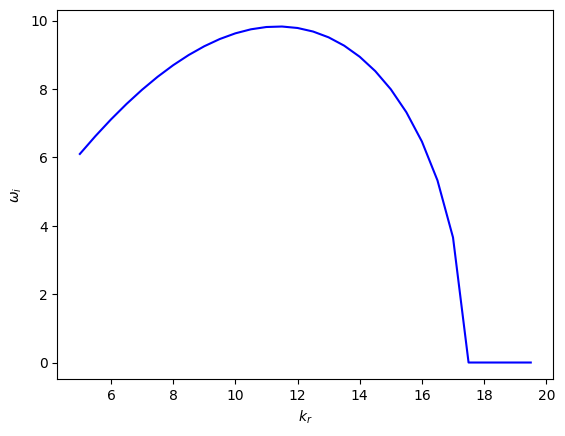

In [24]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w_vals), color='blue')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_9812\3405403774.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

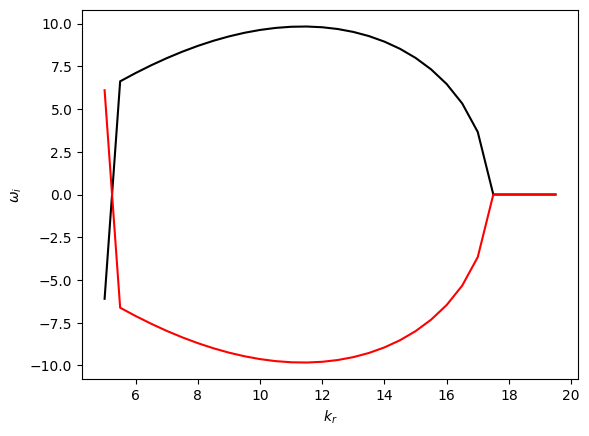

In [25]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w1_vals), color='black')
plt.plot(alpha_r, np.imag(w2_vals), color='red')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

Find the maximum of w_vals and corresponding $k_r$. That $k_r$ will serve as the starting point to get the intial guess for saddle point.

In [26]:
max_imag_w_val = np.max(np.imag(w_vals))
max_imag_w_val_idx = np.argmax(np.imag(w_vals))
k_beg = alpha_r[max_imag_w_val_idx]
w_beg = w_vals[max_imag_w_val_idx]
print(f'k_beg = {np.round(k_beg,3)}')
print(f'w_beg = {np.round(w_beg,3)}')

k_beg = 11.5
w_beg = (18.862+9.826j)


Get the eigenpair $(\mathbf{\hat{q}_1}, \omega_1)$ at the $\alpha$ mode location on the real $k$ line

In [27]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
c_vals, q1_vals = ts.find_c(k_beg)
filter_for_c_vals = [np.isfinite(c_vals)] and c_vals < max_threshold
q1_vals_filtered = []
for i in range(q1_vals.shape[1]):
    if filter_for_c_vals[i]:
        q1_vals_filtered.append(q1_vals[:,i])
q1_hat = np.array(q1_vals_filtered, dtype=complex)
q1_hat = q1_hat.T
c_vals = c_vals[filter_for_c_vals]
w_vals = c_vals * k_beg
if np.imag(w_vals[0]) > np.imag(w_vals[1]):
    w1 = w_vals[0]
else:
    w1 = w_vals[1]
w_vals

array([18.86161371+9.82590479j, 18.86161371-9.82590479j])

In [28]:
class SIVP:
    def __init__(self, sf, bc, val_set=None):
        self.L = bc.A_non_dim * sf.alpha 
        self.M = bc.B_non_dim
        self.L_dot = None
        self.M_dot = None
        self.L_dot_dot = None
        self.M_dot_dot = None
        self.q1_hat = sp.symbols('q1_hat')
        self.q2_hat = sp.symbols('q2_hat')
        self.q3_hat = sp.symbols('q3_hat')
        self.q4_hat = sp.symbols('q4_hat')
        self.q_hat = sp.Matrix([self.q1_hat, self.q2_hat, self.q3_hat, self.q4_hat])
        self.q_hat_herm = self.q_hat.H
        self.J = None
        self.J11 = None
        self.J12 = None
        self.J21 = None
        self.J22 = None
        self.b = None
        self.b1 = None
        self.b2 = None
        self.val_set = val_set
        self.sf = sf
        self.bc = bc

        self.set_L_M_derivs()
        self.set_Jacobian_matrix()
        self.set_b()
        #self.sub_all()

    def set_L_M_derivs(self):
        self.L_dot = self.L.diff(sf.alpha)
        self.M_dot = self.M.diff(sf.alpha)
        self.L_dot_dot = self.L_dot.diff(sf.alpha)
        self.M_dot_dot = self.M_dot.diff(sf.alpha)

    def set_Jacobian_matrix(self):
        self.J11 = self.L - sf.w * self.M
        self.J12 = -self.M * self.q_hat
        self.J21 = self.q_hat_herm
        self.J22 = sp.zeros(1,1)
        self.J = sp.BlockMatrix([[self.J11, self.J12], [self.J21, self.J22]])

    def set_b(self):
        self.b1 = (sf.w * self.M_dot - self.L_dot) * self.q_hat
        self.b2 = sp.zeros(1,1)
        self.b = sp.Matrix.vstack(self.b1, self.b2)

    def sub_all(self, val_set=None):
        if val_set is None:
            if self.val_set is None:
                raise ValueError("val_set must be provided.")
                return
            else:
                val_set = self.val_set

        self.L_sub = self.L.subs(val_set)
        self.M_sub = self.M.subs(val_set)
        self.L_dot_sub = self.L_dot.subs(val_set)
        self.M_dot_sub = self.M_dot.subs(val_set)
        self.L_dot_dot_sub = self.L_dot_dot.subs(val_set)
        self.M_dot_dot_sub = self.M_dot_dot.subs(val_set)   
        self.J11_sub = self.J11.subs(val_set)
        self.J12_sub = self.J12.subs(val_set)
        self.J21_sub = self.J21.subs(val_set)
        self.J22_sub = self.J22.subs(val_set)
        self.J_sub = self.J.subs(val_set)
        self.b1_sub = self.b1.subs(val_set)
        self.b2_sub = self.b2.subs(val_set)
        self.b_sub = self.b.subs(val_set)

    def sub_alpha(self, alpha):
        self.L_sub = self.L_sub.subs({'alpha': alpha})
        self.M_sub = self.M_sub.subs({'alpha': alpha})
        self.L_dot_sub = self.L_dot_sub.subs({'alpha': alpha})
        self.M_dot_sub = self.M_dot_sub.subs({'alpha': alpha})
        self.L_dot_dot_sub = self.L_dot_dot_sub.subs({'alpha': alpha})
        self.M_dot_dot_sub = self.M_dot_dot_sub.subs({'alpha': alpha})
        self.J11_sub = self.J11_sub.subs({'alpha': alpha})
        self.J12_sub = self.J12_sub.subs({'alpha': alpha})
        self.J21_sub = self.J21_sub.subs({'alpha': alpha})
        self.J22_sub = self.J22_sub.subs({'alpha': alpha})
        self.J_sub = self.J_sub.subs({'alpha': alpha})
        self.b1_sub = self.b1_sub.subs({'alpha': alpha})
        self.b2_sub = self.b2_sub.subs({'alpha': alpha})
        self.b_sub = self.b_sub.subs({'alpha': alpha})

    def get_ws_q_hats(self, val_set, alpha):
        L_sub1 = self.L.subs(val_set)
        M_sub1 = self.M.subs(val_set)
        L_sub2 = L_sub1.subs({'alpha': alpha})
        M_sub2 = M_sub1.subs({'alpha': alpha})
        L_num = np.array(L_sub2.evalf()).astype(np.complex128)
        M_num = np.array(M_sub2.evalf()).astype(np.complex128)
        #self.w_vals, self.q_hat_vals = eig(L_num, M_num)
        w_vals, q_hat_vals = eig(L_num, M_num)
        return w_vals, q_hat_vals

    def eval_sub(self, w, q_hat):
        m_val_set = {
            'w':        np.squeeze(w), 
            'q1_hat':   np.squeeze(q_hat[0]), 
            'q2_hat':   np.squeeze(q_hat[1]), 
            'q3_hat':   np.squeeze(q_hat[2]), 
            'q4_hat':   np.squeeze(q_hat[3]),
            }
        self.q_hat_sub = self.q_hat.subs(m_val_set)
        self.q_hat_herm_sub = self.q_hat_herm.subs(m_val_set)
        self.L_sub = self.L_sub.subs(m_val_set)
        self.M_sub = self.M_sub.subs(m_val_set)
        self.L_dot_sub = self.L_dot_sub.subs(m_val_set)
        self.M_dot_sub = self.M_dot_sub.subs(m_val_set)
        self.L_dot_dot_sub = self.L_dot_dot_sub.subs(m_val_set)
        self.M_dot_dot_sub = self.M_dot_dot_sub.subs(m_val_set)
        self.J11_sub = self.J11_sub.subs(m_val_set)
        self.J12_sub = self.J12_sub.subs(m_val_set)
        self.J21_sub = self.J21_sub.subs(m_val_set)
        self.J22_sub = self.J22_sub.subs(m_val_set)
        self.J_sub = self.J_sub.subs(m_val_set)
        self.b1_sub = self.b1_sub.subs(m_val_set)
        self.b2_sub = self.b2_sub.subs(m_val_set)
        self.b_sub = self.b_sub.subs(m_val_set)

        self.L_num = np.array(self.L_sub.evalf()).astype(np.complex128)
        self.M_num = np.array(self.M_sub.evalf()).astype(np.complex128)
        self.q_hat_num = np.array(self.q_hat_sub.evalf()).astype(np.complex128)
        self.q_hat_herm_num = np.array(self.q_hat_herm_sub.evalf()).astype(np.complex128)
        self.J_num = np.array(self.J_sub.evalf()).astype(np.complex128)
        self.b_num = np.array(self.b_sub.evalf()).astype(np.complex128)
        self.J_num_inv = np.linalg.inv(self.J_num)
        self.L_dot_num = np.array(self.L_dot_sub.evalf()).astype(np.complex128)
        self.M_dot_num = np.array(self.M_dot_sub.evalf()).astype(np.complex128)
        self.L_dot_dot_num = np.array(self.L_dot_dot_sub.evalf()).astype(np.complex128)
        self.M_dot_dot_num = np.array(self.M_dot_dot_sub.evalf()).astype(np.complex128)
    
    def eval_x2(self, x1, dk):
        x2 = np.squeeze(x1) + (self.J_num_inv @ self.b_num.ravel()) * dk
        return x2
    
    def eval_xdot(self):
        return self.J_num_inv @ self.b_num.ravel()

    def get_filtered_ws_qhats(self, ws, q_hats, max_threshold):
        filter_for_ws = [np.isfinite(ws)] and ws < max_threshold
        q_hats_filtered = []
        for i in range(q_hats.shape[1]):
            if filter_for_ws[i]:
                q_hats_filtered.append(q_hats[:,i])
        q_hats = np.array(q_hats_filtered, dtype=complex)
        q_hats = q_hats.T
        ws = ws[filter_for_ws]
        return ws, q_hats

    def two_norm_find_matching_x(self, x, ws, q_hats):
        ws, q_hats = self.get_filtered_ws_qhats(ws, q_hats, max_threshold)

        if q_hats.shape[0] == 0:
            print("No valid eigenvalues found.")
            return None
        
        x = np.ravel(x)
        xs = np.vstack((q_hats, ws))
        min_val = np.inf
        idx = 0
        for i in range(xs.shape[1]):
            x_i = np.ravel(xs[:,i])
            val = np.linalg.norm(x - x_i)
            if val < min_val:
                min_val = val
                idx = i
        if min_val > 10:
            print(f"Minimum value: {min_val}")
            print('xs')
            print(xs)
            print('xs[:,idx]')
            print(xs[:,idx])
            print('x')
            print(x)
            print('ws')
            print(ws)
        return xs[:,idx], min_val

val_set = {'S': 0.1, 'Lambda': -2, 'delta': 0.1, 'L':0.0, 's':1}
sivp = SIVP(sf, bc)
sivp.sub_all(val_set)
sivp.sub_alpha(k_beg)
ws, q_hats = sivp.get_ws_q_hats(val_set, k_beg)
q_hat = q_hats[:,1]
q_hat = q_hat[:, np.newaxis]
w = ws[1]
w = w[np.newaxis]
x1 = np.vstack((q_hat, w))
sivp.eval_sub(ws[0], q_hats[:,0])
k1 = k_beg
k2 = k1 + 0.1j
dk = k2 - k1
x2 = sivp.eval_x2(x1, dk)
#x2

In [29]:
# construct global map of wi(k):
# From the kr value that corresponds to maximum temporal grwoth rate, increment k with dk, dk being imaginary to fill out kr_max + j*ki.
# We are finding each value vertically in the kr-ki plane first and then for each row, we find the left and the right of the known kr_max + j*ki value
# That recovers the entire global map

# some required params
max_threshold = 1e6

# create the wavenumber space
#alpha_r = np.arange(0,20,0.5)
#alpha_i = np.arange(-10,10,0.5)
#alpha_r = np.arange(5,20,0.5)
#alpha_i = np.arange(-5,5,0.5)
alpha_r = np.arange(0,20,0.5)
alpha_i = np.arange(-10,10,0.5)

alpha_R, alpha_I = np.meshgrid(alpha_r, alpha_i)
w_vals = np.zeros_like(alpha_R, dtype=complex)
visited = np.zeros_like(alpha_R, dtype=bool)

# find the index of maximum growth rate from temporal stability analysis
kr_beg_idx = np.argmin(np.abs(alpha_r - k_beg))
ki_beg_idx = np.argmin(np.abs(alpha_i))
k1 = alpha_R[ki_beg_idx, kr_beg_idx] + 1j * alpha_I[ki_beg_idx, kr_beg_idx]
w_vals[ki_beg_idx, kr_beg_idx] = ws[1]

# mark that index as visited
visited[ki_beg_idx, kr_beg_idx] = True 

# from that index, traverse upward in the alpha_I direction
#curr_imag_idx = ki_beg_idx + 1
#w1 = ws[0]
#q_hat1 = q_hats[:,0]
#k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
#dk = k2 - k1

val_set = {'S': 0.1, 'Lambda': -2.0, 'delta': 0.1, 'L':0.0, 's':1}
sivp = SIVP(sf, bc)

def get_matching_x(x1, k1, k2):
    sivp.sub_all(val_set)
    sivp.sub_alpha(k1)
    sivp.eval_sub(x1[-1], x1[:-1])
    x2 = sivp.eval_x2(x1, k2 - k1)
    ws, q_hats = sivp.get_ws_q_hats(val_set, k2)
    #print('DEBUG')
    #print(x2)
    result = sivp.two_norm_find_matching_x(x2, ws, q_hats)
    if result is None:
        return None, None
    matching_x = result[0]
    min_val = result[1]
    return matching_x, min_val

# to store all x1 values along the imaginary axis for each ki and fixed dominant alpha-mode kr
x1_dom = [x1]
x1_up_list = [] 
x1_down_list = [] 

# go upward in the ki direction
curr_imag_idx = ki_beg_idx + 1
while curr_imag_idx < alpha_I.shape[0]:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0] - 1}')
    k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    result = get_matching_x(x1, k1, k2)
    if result is None:
        x2 = None
        min_val = -1
    else:
        x2 = result[0]
        min_val = result[1]
    if x2 is None:
        w_vals[curr_imag_idx, kr_beg_idx] = np.nan
    else:
        w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    if min_val > 10:
        print(f'(ki,kr): ({curr_imag_idx},{kr_beg_idx})')
    w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    visited[curr_imag_idx, kr_beg_idx] = True
    x1_up_list.append(x2)
    x1 = x2
    k1 = k2
    curr_imag_idx += 1

# go downward in the ki direction
curr_imag_idx = ki_beg_idx - 1
while curr_imag_idx >= 0:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0] - 1}')
    k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    result = get_matching_x(x1, k1, k2)
    if result is None:
        x2 = None
        min_val = -1
    else:
        x2 = result[0]
        min_val = result[1]
    if x2 is None:
        w_vals[curr_imag_idx, kr_beg_idx] = np.nan
    else:
        w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    if min_val > 10:
        print(f'(ki,kr): ({curr_imag_idx},{kr_beg_idx})')
    w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    visited[curr_imag_idx, kr_beg_idx] = True
    x1_down_list.append(x2)
    x1 = x2
    k1 = k2
    curr_imag_idx -= 1

x1_down_list.reverse()
x1_list = sum([x1_down_list, x1_dom, x1_up_list], [])

curr_imag_idx = 0
while curr_imag_idx < alpha_I.shape[0]:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0] - 1}')
    # go left in the kr direction
    k1 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    curr_real_idx = kr_beg_idx - 1
    x1 = x1_list[curr_imag_idx]
    while curr_real_idx >= 0:
        #print(f'curr_real_idx = {curr_real_idx}/ {alpha_I.shape[1] - 1}')
        k2 = alpha_R[curr_imag_idx, curr_real_idx] + 1j * (alpha_I[curr_imag_idx, curr_real_idx])
        result = get_matching_x(x1, k1, k2)
        if result is None:
            x2 = None
            min_val = -1
        else:
            x2 = result[0]
            if result[1] is None:
                min_val = -1
            else:
                min_val = result[1]
        if min_val > 10:
            print(f'(ki,kr): ({curr_imag_idx},{curr_real_idx})')
        if x2 is None:
            w_vals[curr_imag_idx, curr_real_idx] = np.nan
        else:
            w_vals[curr_imag_idx, curr_real_idx] = x2[-1]
            x1 = x2
        k1 = k2
        visited[curr_imag_idx, curr_real_idx] = True
        curr_real_idx -= 1
    # go right in the kr direction
    k1 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    curr_real_idx = kr_beg_idx + 1
    x1 = x1_list[curr_imag_idx]
    while curr_real_idx < alpha_I.shape[1]:
        #print(f'curr_real_idx = {curr_real_idx}/ {alpha_I.shape[1] - 1}')
        k2 = alpha_R[curr_imag_idx, curr_real_idx] + 1j * (alpha_I[curr_imag_idx, curr_real_idx])
        result = get_matching_x(x1, k1, k2)
        if result is None:
            x2 = None
            min_val = -1
        else:
            x2 = result[0]
            if result[1] is None:
                min_val = -1
            else:
                min_val = result[1]
        if min_val > 10:
            print(f'(ki,kr): ({curr_imag_idx},{curr_real_idx})')
        if x2 is None:
            w_vals[curr_imag_idx, curr_real_idx] = np.nan
        else:
            w_vals[curr_imag_idx, curr_real_idx] = x2[-1]
            x1 = x2
        k1 = k2
        visited[curr_imag_idx, curr_real_idx] = True
        curr_real_idx += 1
    curr_imag_idx += 1
    


# contourf plot the map and verify its correctness

curr_imag_idx = 21/ 39
curr_imag_idx = 22/ 39
curr_imag_idx = 23/ 39
curr_imag_idx = 24/ 39
curr_imag_idx = 25/ 39
curr_imag_idx = 26/ 39


KeyboardInterrupt: 

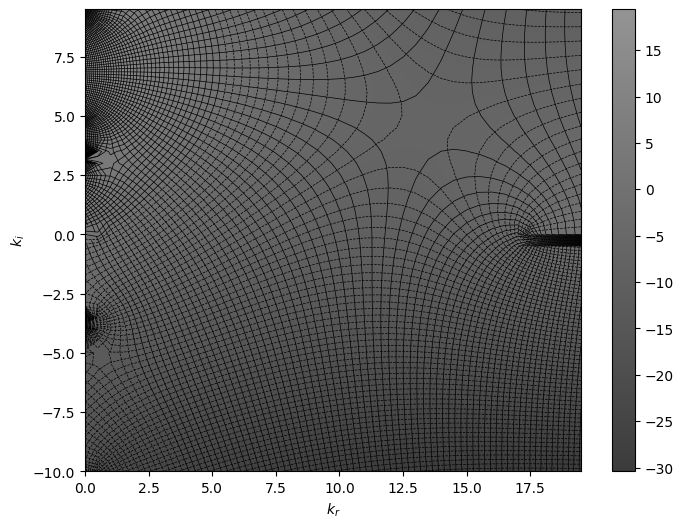

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(alpha_R, alpha_I, np.imag(w_vals), levels=250)
cbar = plt.colorbar(cs)
cs.set_clim(-64, 80)
ax.contour(alpha_R, alpha_I, np.imag(w_vals), levels=100, colors='black', linewidths=0.5)
ax.contour(alpha_R, alpha_I, np.real(w_vals), levels=100, colors='black', linewidths=0.5)
# set colormap to jet
cs.set_cmap('gray')
ax.set_xlabel('$k_r$')
ax.set_ylabel('$k_i$')
#ax.set_xlim(0, 3.5)
#ax.set_ylim(-4, 4)
plt.ion()
plt.show()

In [ ]:
import scipy.io as sio
sio.savemat('C:\\Users\\tvivek\\Desktop\\w_vals_imag_sivp_w1.mat', {'w_vals': w_vals, 'alpha_R': alpha_R, 'alpha_I': alpha_I})

In [ ]:
# From the guess \alpha of saddle point, iterate to the actual saddle point
k0js = []
iter_num = 0
iter_max = 50
dk = np.inf
dk_thres = 1e-8
k0j1 = 11.5 - 3.5j
k0js.append(k0j1)

# begin with w and qhat at k0j1. Use that to get k0j2.
# Then in steps, move from k0j1 to k0j2 like we did for 
# getting the global map. Use this procedure to reach k0j2 
# with the obtained values of w2 and qhat2. Repeat this process
# until convergence, i.e. abs(k0j1 - k0j2) < dk_thres

def get_J2_inv(sivp, w, qhat):
    J2_11 = sivp.L_num - w * sivp.M_num
    J2_12 = -sivp.M_num @ qhat.ravel()
    J2_12 = J2_12[:, np.newaxis]
    J2_21 = np.conjugate(qhat)
    J2_21 = J2_21[:, np.newaxis].transpose()
    J2_22 = np.zeros((1,1))
    J2 = np.block([[J2_11, J2_12], [J2_21, J2_22]])
    J2_inv = np.linalg.inv(J2)
    return J2_inv

def get_b2(sivp, w, qhat, qhat_dot, qhat_dot_herm):
    b2_11_term1 = 2 * ( (w * sivp.M_dot_num + w_dot * sivp.M_num - sivp.L_dot_num) )
    b2_11_term2 = w * sivp.M_dot_dot_num - sivp.L_dot_dot_num + 2 * w_dot * sivp.M_dot_num
    b2_11 = b2_11_term1 @ qhat_dot.ravel() + b2_11_term2 @ qhat.ravel()
    b2_22 = - qhat_dot_herm.ravel() @ qhat_dot.ravel()
    b2 = np.append(b2_11, b2_22)
    return b2

def get_zigzag_path_k0j(k0j1, k0j2, step=0.1):
    path = [k0j1]
    current = k0j1
    toggle = False
    if np.real(k0j1) > np.real(k0j2):
        inc_re_sign = -1
    else:
        inc_re_sign = 1
    if np.imag(k0j1) > np.imag(k0j2):
        inc_im_sign = -1
    else:
        inc_im_sign = 1
    num_re_inc = int(np.ceil(np.abs(np.real(k0j2) - np.real(k0j1))/step))
    num_im_inc = int(np.ceil(np.abs(np.imag(k0j2) - np.imag(k0j1))/step))
    while num_re_inc > 0 or num_im_inc > 0:
        if toggle and num_re_inc > 0:
            if np.abs(np.real(k0j2) - np.real(current)) < step:
                next_point = np.real(k0j2) + 1j*np.imag(current)
            else:
                next_point = current + inc_re_sign * step
            path.append(next_point)
            num_re_inc -= 1
        if not toggle and num_im_inc > 0:
            if np.abs(np.imag(k0j2) - np.imag(current)) < step:
                next_point = np.real(current) + np.imag(k0j2)*1j
            else:
                next_point = current + inc_im_sign * step * 1j
            path.append(next_point)
            num_im_inc -= 1
        current = next_point
        toggle = not toggle
    return path

def get_x_multi_SIVP(k0j1, k0j2, w, qhat):
    if np.abs(k0j1 - k0j2) < 1e-8:
        return w, qhat
    #Get the path to traverse from k0j1 to k0j2 using SIVP
    k0js = get_zigzag_path_k0j(k0j1, k0j2)
    print(k0js)

    # traverse the path and find the w and qhat at each step
    k_idx = 1
    k1 = k0js[0]
    x1 = np.concatenate((qhat, [w]))
    while k_idx < len(k0js):
        k2 = k0js[k_idx]
        result = get_matching_x(x1, k1, k2)
        if result is None:
            x2 = None
        else:
            x2 = result[0]
        if x2 is not None:
            x1 = x2
        k1 = k2
        k_idx += 1
    return x2[-1], x2[:-1]

ws, q_hats = sivp.get_ws_q_hats(val_set, k0j1)
ws, q_hats = sivp.get_filtered_ws_qhats(ws, q_hats, max_threshold)
w = ws[1]
qhat = q_hats[:,1]

print('ws')
print(ws)
print('w')
print(w)

while iter_num < iter_max and dk > dk_thres:
    print('iter_num', iter_num)
    sivp.sub_all(val_set)
    sivp.sub_alpha(k0j1)
    sivp.eval_sub(w, qhat)
    xdot = sivp.eval_xdot()
    w_dot = xdot[-1]
    qhat_dot = xdot[:-1]
    qhat_dot_herm = np.conjugate(qhat_dot)
    qhat_dot_herm = qhat_dot_herm[:, np.newaxis].transpose()

    J2_inv = get_J2_inv(sivp, w, qhat)
    b2 = get_b2(sivp, w, qhat, qhat_dot, qhat_dot_herm)

    x_dot_dot = J2_inv @ b2.ravel()
    d2wdk2 = x_dot_dot[-1]

    k0j2 = k0j1 - w_dot/d2wdk2

    w, qhat = get_x_multi_SIVP(k0j1, k0j2, w, qhat)

    k0js.append(k0j2)
    dk = np.abs(k0j2 - k0j1)
    k0j1 = k0j2
    iter_num += 1

ws
[18.9618722 -15.17909982j 19.14676922 +7.12220878j]
w
(19.14676922299102+7.122208783164254j)
iter_num 0
[(11.5-3.5j), (11.5-3.6j), (11.6-3.6j), (11.6-3.7j), (11.7-3.7j), (11.7-3.8000000000000003j), (11.799999999999999-3.8000000000000003j), (11.799999999999999-3.9000000000000004j), (11.899999999999999-3.9000000000000004j), (11.899999999999999-4j), (11.999999999999998-4j), (11.999999999999998-4.1j), (12.099999999999998-4.1j), (12.099999999999998-4.199999999999999j), (12.199999999999998-4.199999999999999j), (12.199999999999998-4.299999999999999j), (12.299999999999997-4.299999999999999j), (12.299999999999997-4.399999999999999j), (12.399999999999997-4.399999999999999j), (12.399999999999997-4.499999999999998j), (12.499999999999996-4.499999999999998j), (12.499999999999996-4.599999999999998j), (12.599999999999996-4.599999999999998j), (12.599999999999996-4.6999999999999975j), (12.699999999999996-4.6999999999999975j), np.complex128(12.699999999999996-4.719056873295734j), np.complex128(12.7999

In [72]:
# Repeat for a range of S and Lambda vals
iter_max = 50
dk_thres = 1e-8

#k0j1 = 1.5 + -6.5j # for neg L range - varicose
k0j1 = 1 - 7j # for pos L range - varicose
#k0j1 = 1 - 3j # for neg L range - sinuous
#k0j1 = 1 - 3.5j # for pos L range - sinuous 

ws, q_hats = sivp.get_ws_q_hats(val_set, k0j1)
ws, q_hats = sivp.get_filtered_ws_qhats(ws, q_hats, max_threshold)
print(ws)

#w = ws[1] # for neg L range = varicose
w = ws[0]  # for pos L range - varicose
#w = ws[1] # for neg L range - sinuous
#w = ws[0]  # for pos L range - sinuous

#qhat = q_hats[:,1] for neg L range - varicose 
qhat = q_hats[:,0] # for pos L range - varicose
#qhat = q_hats[:,1] # for pos L range - sinuous
#qhat = q_hats[:,0] # for pos L range - sinuous

S_range = np.logspace(-1, 1, 13)
#Lambda_range = np.linspace(-2, -0.25, 13)
Lambda_range = np.linspace(0.25, 2, 13)
L, S = np.meshgrid(Lambda_range, S_range)
w_vals = np.zeros_like(S, dtype=complex)
w_vals[0,0] = w
k0j1_vals = np.zeros_like(S, dtype=complex)
k0j1_vals[0,0] = k0j1
q_hat_vals = np.zeros((S.shape[0], S.shape[1], len(qhat)), dtype=complex)
q_hat_vals[0,0,:] = qhat

for SL_idx in range(S.shape[0]):
    if SL_idx == 0:
        SL_jdx_beg = 1
    else:
        SL_jdx_beg = 0
    for SL_jdx in range(SL_jdx_beg,S.shape[1]):
        if SL_jdx == 0:
            k0j1 = k0j1_vals[SL_idx-1, SL_jdx]
            w = w_vals[SL_idx-1, SL_jdx]
            qhat = q_hat_vals[SL_idx-1, SL_jdx, :]
        else:
            k0j1 = k0j1_vals[SL_idx, SL_jdx-1]
            w = w_vals[SL_idx, SL_jdx-1]
            qhat = q_hat_vals[SL_idx, SL_jdx-1, :]
        #if np.abs(L[SL_idx, SL_jdx]) < 0.1:
        #    w_vals[SL_idx, SL_jdx] = w
        #    q_hat_vals[SL_idx, SL_jdx, :] = qhat
        #    k0j1_vals[SL_idx, SL_jdx] = k0j1
        #    continue
        val_set = {'S': S[SL_idx, SL_jdx], 'Lambda': L[SL_idx, SL_jdx], 'delta': 0.1, 'L':0.0, 's':-1}
        print(val_set)
        iter_num = 0
        dk = np.inf
        while iter_num < iter_max and dk > dk_thres:
            print('iter_num', iter_num)
            sivp.sub_all(val_set)
            sivp.sub_alpha(k0j1)
            sivp.eval_sub(w, qhat)
            xdot = sivp.eval_xdot()
            w_dot = xdot[-1]
            qhat_dot = xdot[:-1]
            qhat_dot_herm = np.conjugate(qhat_dot)
            qhat_dot_herm = qhat_dot_herm[:, np.newaxis].transpose()

            J2_inv = get_J2_inv(sivp, w, qhat)
            b2 = get_b2(sivp, w, qhat, qhat_dot, qhat_dot_herm)

            x_dot_dot = J2_inv @ b2.ravel()
            d2wdk2 = x_dot_dot[-1]

            k0j2 = k0j1 - w_dot/d2wdk2

            if np.abs(k0j2 - k0j1) > 15:
                print('Convergence failed')
                k0j2 = k0j1
                if SL_idx > 0:
                    w = w_vals[SL_idx-1, SL_jdx]
                    qhat = q_hat_vals[SL_idx-1, SL_jdx, :]
                    k0j1 = k0j1_vals[SL_idx-1, SL_jdx]
                    k0j2 = k0j1_vals[SL_idx-1, SL_jdx]
                else:
                    w = w_vals[SL_idx, SL_jdx]
                    qhat = q_hat_vals[SL_idx, SL_jdx - 1, :]
                    k0j1 = k0j1_vals[SL_idx, SL_jdx - 1]
                    k0j2 = k0j1_vals[SL_idx, SL_jdx - 1]
                break

            w, qhat = get_x_multi_SIVP(k0j1, k0j2, w, qhat)

            dk = np.abs(k0j2 - k0j1)
            k0j1 = k0j2
            iter_num += 1
        w_vals[SL_idx, SL_jdx] = w
        q_hat_vals[SL_idx, SL_jdx, :] = qhat
        k0j1_vals[SL_idx, SL_jdx] = k0j1

[ 2.29620781-5.12076452j -2.38198939-6.8918814j ]
{'S': np.float64(0.1), 'Lambda': np.float64(0.39583333333333337), 'delta': 0.1, 'L': 0.0, 's': -1}
iter_num 0
[np.complex128(1-7j), np.complex128(1-7.1j), np.complex128(0.9-7.1j), np.complex128(0.9-7.166514593882903j), np.complex128(0.8-7.166514593882903j), np.complex128(0.7000000000000001-7.166514593882903j), np.complex128(0.698036866147622-7.166514593882903j)]
iter_num 1
[np.complex128(0.698036866147622-7.166514593882903j), np.complex128(0.698036866147622-7.114796811123452j), np.complex128(0.7742156366679656-7.114796811123452j)]
iter_num 2
[np.complex128(0.7742156366679656-7.114796811123452j), np.complex128(0.7742156366679656-7.097926633063041j), np.complex128(0.7808900989826612-7.097926633063041j)]
iter_num 3
[np.complex128(0.7808900989826612-7.097926633063041j), np.complex128(0.7808900989826612-7.097499356488352j), np.complex128(0.780522218409227-7.097499356488352j)]
iter_num 4
[np.complex128(0.780522218409227-7.097499356488352j), n

In [ ]:
import scipy.io as sio
sio.savemat('C:\\Users\\tvivek\\Desktop\\w_SL2.mat', {'S': S, 'L': L, 'w_vals': w_vals, 'q_hat_vals': q_hat_vals, 'k0j1_vals': k0j1_vals})   